## Extracting the preprocessed data

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import ast
from sklearn.preprocessing import StandardScaler

# Load the pickle file
df_train = pd.read_pickle("train_subdivided_data.pkl")
df_test = pd.read_pickle("test_subdivided_data.pkl")

# Prepare features
embeddings_train = np.vstack(df_train['ConcatenatedEmbeddings'].values)
period_ids_train = df_train['PeriodID'].values.reshape(-1, 1)  # Reshape to match dimensions for concatenation
embeddings_test = np.vstack(df_test['ConcatenatedEmbeddings'].values)
period_ids_test = df_test['PeriodID'].values.reshape(-1, 1)  # Reshape to match dimensions for concatenation

# Concatenate PeriodID as an additional feature
X_train = np.hstack([embeddings_train, period_ids_train])  # X now has shape (n_samples, 4001)
X_test = np.hstack([embeddings_test, period_ids_test])  # X now has shape (n_samples, 4001)

# Scaling before using
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Prepare labels
y_train = df_train['EventType']
y_test = df_test['EventType']

# Encode labels if necessary
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

# Verify the shapes
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

num_negatives = (y_train == 0).sum()
num_positives = (y_train == 1).sum()

print("Zeros: " + str(num_negatives))
print("Ones: " + str(num_positives))

pos_weight_value = num_negatives / num_positives

print("Ratio: " + str(pos_weight_value))

Shape of X_train: (1617, 4001)
Shape of X_test: (520, 4001)
Shape of y_train: (1617,)
Shape of y_test: (520,)
Zeros: 740
Ones: 877
Ratio: 0.8437856328392246


In [2]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Converting data to pytorch tensors to allow 

pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create a dataset and data loader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## The neural network

In [3]:
import torch.nn as nn
import torch.optim as optim
from challenge_data.glove_nn import NeuralNet, train

torch.manual_seed(42)

# Hyperparameters
lr = 0.1
num_epochs = 60
slope = 0.0000001
gamma = 0.9


model = NeuralNet(input_size=4001, slope=slope)

# Binary Cross Entropy Loss for binary classification
criterion = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)

optimizer = optim.Adam(model.parameters(), lr=lr) 

scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma) 

In [4]:
from sklearn.metrics import accuracy_score
import numpy as np

# Training
loss_list1 = train(num_epochs=num_epochs, 
                  model=model, 
                  train_loader=train_loader, 
                  criterion=criterion, 
                  optimizer=optimizer, 
                  scheduler=scheduler,
)

# Evaluation on the test set
model.eval()
with torch.no_grad():
    y_pred_list = []
    for X_batch, _ in test_loader:
        outputs = model(X_batch)
        y_pred_list.extend(outputs.numpy())

y_pred = (np.array(y_pred_list) > 0.5).astype(int)  # Adjust threshold for binary classification

# Print test set accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy:", accuracy)

100%|███████████████████████████████████████████████████████████████| 60/60 [00:41<00:00,  1.44it/s]

Test set accuracy: 0.6365384615384615


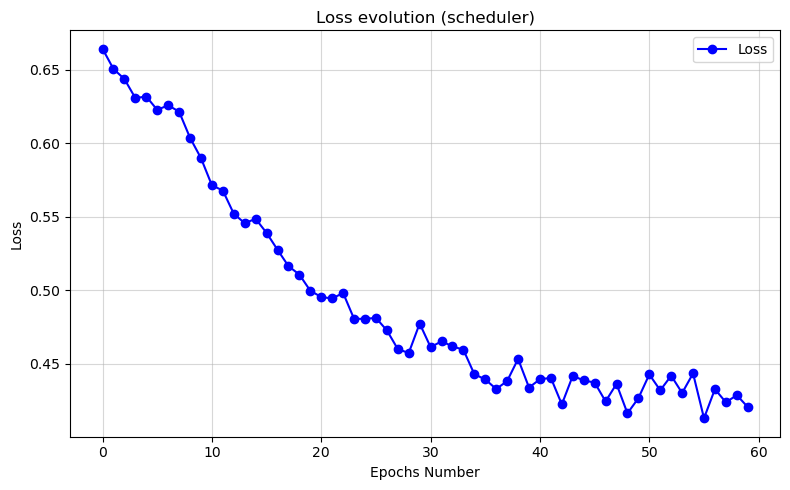

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(loss_list1, marker='o', linestyle='-', color='b', label='Loss')
plt.title("Loss evolution (scheduler)")
plt.xlabel("Epochs Number")
plt.ylabel("Loss")
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

## Submission

In [6]:
# Load the pickle file
df_eval = pd.read_pickle("eval_subdivided_data.pkl")
print(len(df_eval))

# Prepare features
embeddings_eval = np.vstack(df_eval['ConcatenatedEmbeddings'].values)
period_ids_eval = df_eval['PeriodID'].values.reshape(-1, 1)  # Reshape to match dimensions for concatenation

# Concatenate PeriodID as an additional feature
X_eval = np.hstack([embeddings_eval, period_ids_eval])  # X now has shape (n_samples, 4001)

X_eval_tensor = torch.tensor(X_eval, dtype=torch.float32)

516


In [7]:
# Evaluation on the eval set
model.eval()
with torch.no_grad():
    outputs = model(X_eval_tensor)

y_eval_pred = (np.array(outputs) > 0.5).astype(int)  # Adjust threshold for binary classification

df_eval['EventType'] = y_eval_pred

result_df = df_eval[['ID', 'EventType']]

# Exporter le résultat au format CSV
result_df.to_csv('eval_predictions_mlp.csv', index=False)

print("Predictions saved in 'eval_predictions_mlp.csv'.")

Predictions saved in 'eval_predictions_mlp.csv'.


## Random forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 150, 300], 
    'max_depth': [40, 30, 20, None], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt']
}

# Grid Search with cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # Metric to optimize
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.2f}")

# Evaluate on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {accuracy:.2f}")

Fitting 5 folds for each of 144 candidates, totalling 720 fits


KeyboardInterrupt: 

## Logistic regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA

n_components=1000
pca = PCA(n_components=n_components)  # Reduce to 1000 features
X_train_log = pca.fit_transform(X_train)
X_test_log = pca.transform(X_test)

# Initialize the logistic regression model
logistic_model = LogisticRegression(penalty='l2', C=0.4, max_iter=1000)

# Train the model
logistic_model.fit(X_train_log, y_train)

# Make predictions
y_pred_log = logistic_model.predict(X_test_log)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_log)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.58


## SKLearn MLP

In [10]:
from sklearn.neural_network import MLPClassifier

# Define the parameters
params = {
    'hidden_layer_sizes': (4000, 1000, 500, 200),
    'activation': 'relu',
    'solver': 'adam',
}

# Create the MLP model
mlp_model = MLPClassifier(**params, random_state=42, max_iter=500)

# Fit the random search model
mlp_model.fit(X_train, y_train)

y_pred = mlp_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.4f}")

Test set accuracy: 0.6135


In [6]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Define the model
mlp = MLPClassifier(max_iter=500, random_state=42)

# Define the parameter distribution
param_dist = {
    'hidden_layer_sizes': [(2048, 512, 128, 64), (4000, 1000, 500, 200), (128, 64, 32, 16)],  
    'activation': ['relu'],  
    'solver': ['adam'],  
    'alpha': [0.00001, 0.0001, 0.001],  
    'learning_rate': ['invscaling'],  
    'learning_rate_init': [0.0001, 0.001, 0.01], 
    'batch_size': [128, 256] 
}

# Set up the GridSearchCV
grid_search = GridSearchCV(
        estimator=mlp,
        param_grid=param_dist,
        scoring='accuracy',
        cv=5,  # 5-fold cross-validation
        verbose=2,  # Increase output verbosity for debugging
        n_jobs=-1   # Use all available processors
    )

# Fit the random search model
grid_search.fit(X_train, y_train)

# Print the best parameters found
print("Best hyperparameters found: ", grid_search.best_params_)

# Use the best model to make predictions on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {accuracy:.4f}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits


KeyboardInterrupt: 